<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_ARIMA_Not_Seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install yfinance

In [34]:
!pip install pmdarima statsmodels scikit-learn

In [35]:
#!pip install --upgrade scikit-learn pmdarima

In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load Data

In [37]:
start_date = datetime(2007, 3, 18)
end_date = datetime (2025, 3, 18)
ticker = 'BTC-USD'
df =yf.download(ticker, start=start_date, end=end_date)['Close']
df = df.rename(columns={ticker:'y'})
df = df.resample('ME').last()


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

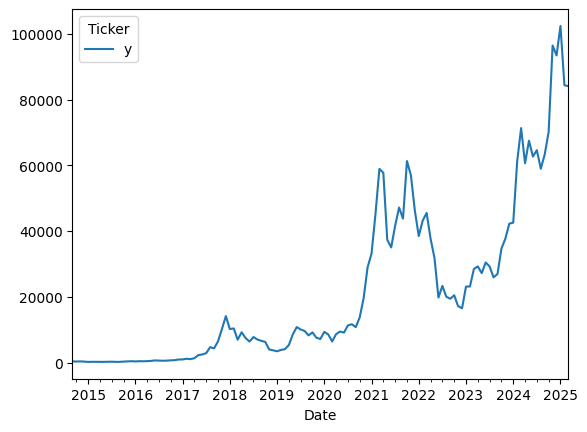

In [38]:
df.plot()

## Train / Test

In [39]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
h = len(test)
print(train.shape)
print(test.shape)
train.head()

(88, 1)
(39, 1)


Ticker,y
Date,
2014-09-30,386.944000
2014-10-31,338.321014
2014-11-30,378.046997
2014-12-31,320.192993
2015-01-31,217.464005


# Analysis

In [40]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    dftest = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(dftest[0:4],index=labels)

    for key,val in dftest[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())

    if dftest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

def ljungbox_test(serie):
    """
    Aplica o teste de Ljung-Box para verificar autocorrelação nos resíduos.
    """
    from statsmodels.stats.diagnostic import acorr_ljungbox

    ljung_box_results = acorr_ljungbox(serie, return_df=True, lags=[20])

    p_value = ljung_box_results['lb_pvalue'].values[0]
    print('\nLJung-Box Test\nH0:has no autocorrelation\n')
    alpha = 0.05
    print(f'p-valor = {round(p_value,2)}\nalpha = {round(alpha,2)}')
    if p_value < alpha:
        print('Data has autocorrelation')
    else:
        print('Data has no autocorrelation')


In [41]:
adf_test(train)

Augmented Dickey-Fuller Test: 
ADF test statistic       0.141828
p-value                  0.968804
# lags used              6.000000
# observations          81.000000
critical value (1%)     -3.513790
critical value (5%)     -2.897943
critical value (10%)    -2.586191
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Definindo 'd'

**1ª diff**

In [42]:
diff1 = train.copy()
diff1['y'] = diff1['y'].diff(1)
diff1.dropna(inplace=True)
diff1.head()

Ticker,y
Date,
2014-10-31,-48.622986
2014-11-30,39.725983
2014-12-31,-57.854004
2015-01-31,-102.728989
2015-02-28,36.798996


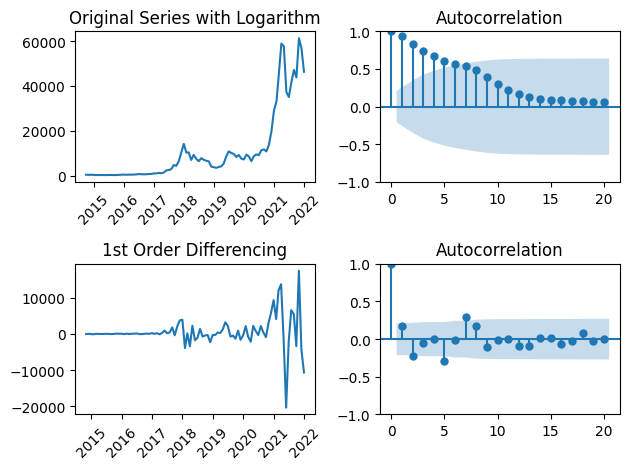

In [43]:
fig, axes = plt.subplots(2, 2, )
axes[0, 0].plot(train); axes[0, 0].set_title('Original Series with Logarithm')
plot_acf(train, ax=axes[0, 1],lags=20)

axes[1, 0].plot(diff1); axes[1, 0].set_title('1st Order Differencing')
plot_acf(diff1, ax=axes[1, 1],lags=20)

# Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
for ax in axes[:, 0]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

In [44]:
adf_test(diff1)

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.389998
p-value                  0.011305
# lags used              5.000000
# observations          81.000000
critical value (1%)     -3.513790
critical value (5%)     -2.897943
critical value (10%)    -2.586191
Reject the null hypothesis
Data has no unit root and is stationary


* A série já parece bastante estacionária visualmente.

* A ACF mostra poucos lags significativos (quase todos dentro da banda de confiança).

* Isso indica que a 1ª diferenciação pode ser suficiente.

**2ª diff**

In [45]:
diff2 = diff1.copy()
diff2['y'] = diff2['y'].diff(1)
diff2.dropna(inplace=True)
diff2.head()

Ticker,y
Date,
2014-11-30,88.348969
2014-12-31,-97.579987
2015-01-31,-44.874985
2015-02-28,139.527985
2015-03-31,-46.837997


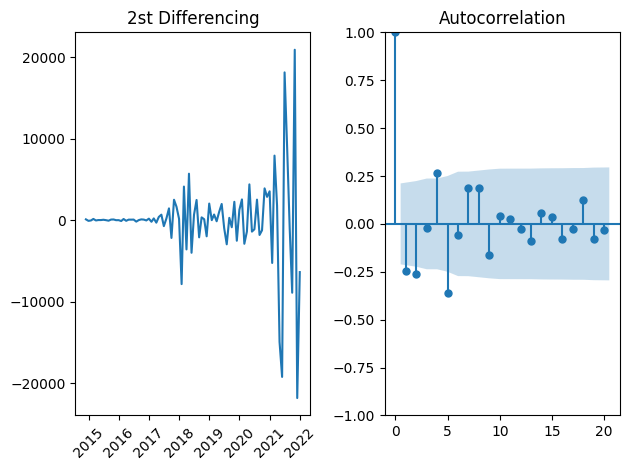

In [46]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(diff2); axes[0].set_title('2st Differencing')
axes[1].set(ylim=(0,5))
plot_acf(diff2, ax=axes[1],lags=20)

# Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
plt.tight_layout()
plt.show()

* A 2ª diferenciação ganhou ainda mais oscilação.
* Mais lags se tornam significativos negativamente, o que pode indicar superdiferenciação.

**Conclusão**

* A 1ª diferenciação é suficiente

In [47]:
d = 1

## Definindo 'p'

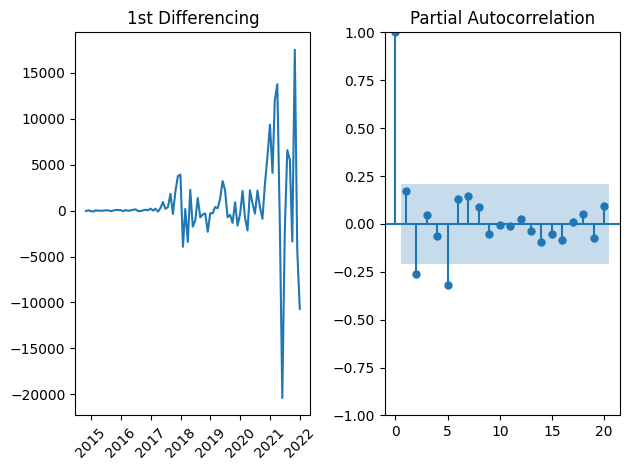

In [48]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(diff1); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff1, ax=axes[1],lags=20)

# Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
plt.tight_layout()
plt.show()

In [49]:
p = 5

## Definindo 'q'

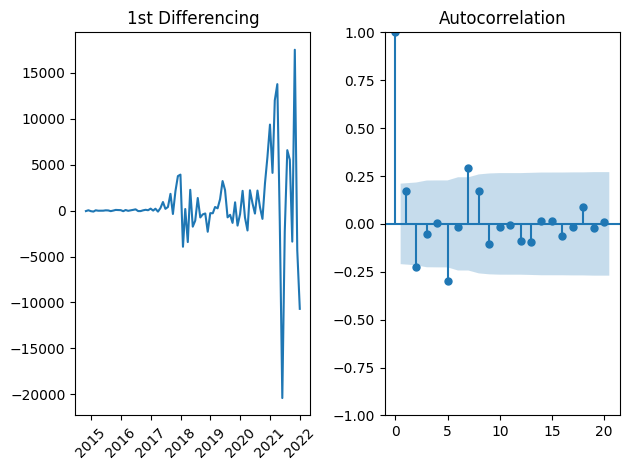

In [50]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(diff1); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(diff1, ax=axes[1], lags=20)

# Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
plt.tight_layout()

plt.show()

In [51]:
ljungbox_test(diff1)


LJung-Box Test
H0:has no autocorrelation

p-valor = 0.05
alpha = 0.05
Data has no autocorrelation


In [52]:
q = 7

# Modelo ARIMA

## Arima(5,1,7)

In [53]:
arima_517 = ARIMA(train, order=(5,1,7))
fitted_517 = arima_517.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
# summary of fit model
print(fitted_517.summary())
# residuals
resid_517 = DataFrame(fitted_517.resid)
# summary stats of residuals
print(resid_517.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:                 ARIMA(5, 1, 7)   Log Likelihood                -829.225
Date:                Sun, 30 Mar 2025   AIC                           1684.450
Time:                        23:12:50   BIC                           1716.507
Sample:                    09-30-2014   HQIC                          1697.358
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2324      0.367      0.633      0.527      -0.487       0.952
ar.L2         -0.2236      0.423     -0.528      0.597      -1.053       0.606
ar.L3         -0.1939      0.465     -0.417      0.6

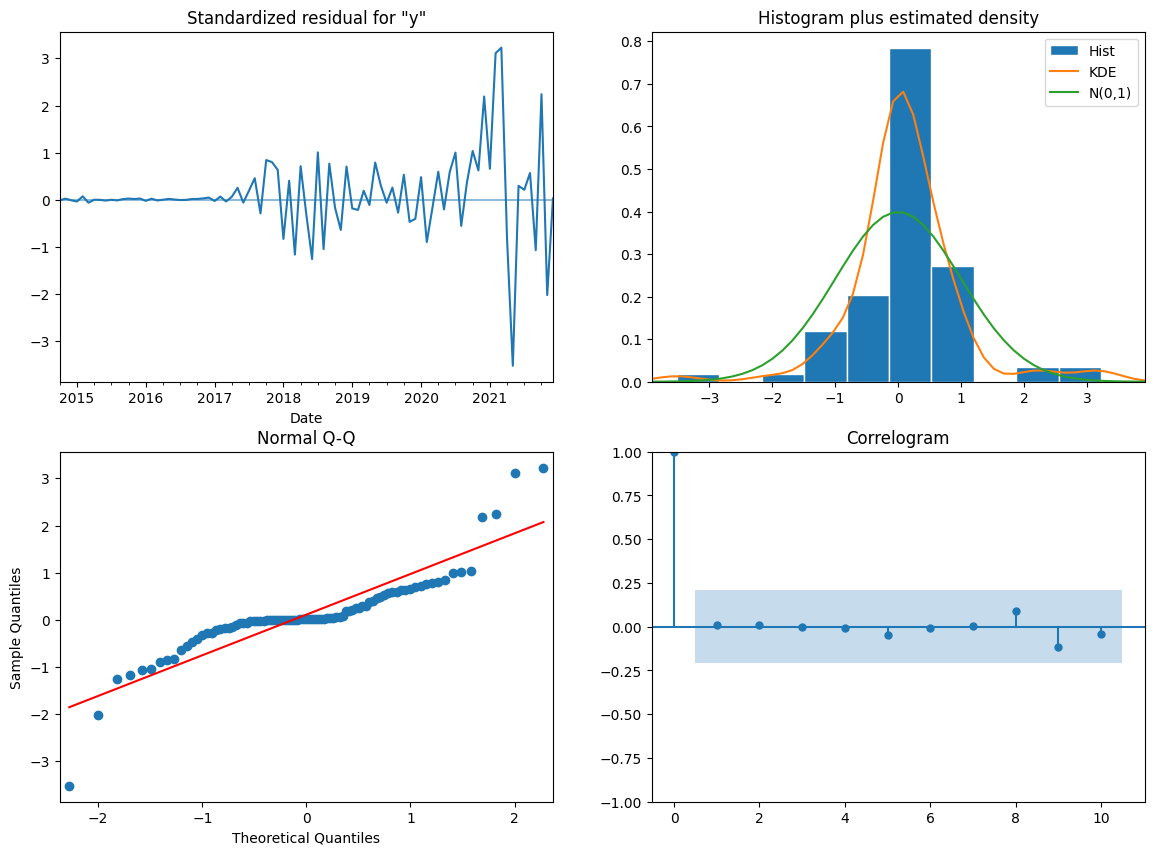

In [55]:
fig = fitted_517.plot_diagnostics(figsize=(14,10))
plt.show()

<Axes: xlabel='ds'>

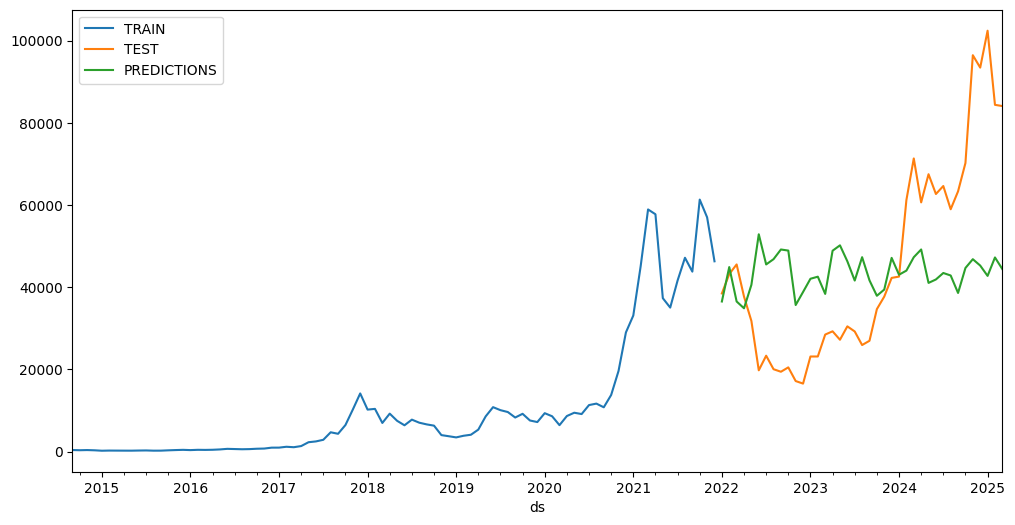

In [56]:
predictions_517 = predictions = fitted_517.forecast(len(test))
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':predictions_517}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo AR

## AR(5)

In [57]:
ar5 = ARIMA(train, order=(5,0,0))
fitted_ar5 = ar5.fit()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -856.500
Date:                Sun, 30 Mar 2025   AIC                           1727.000
Time:                        23:12:51   BIC                           1744.341
Sample:                    09-30-2014   HQIC                          1733.986
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.08e+04   3.29e+04      0.328      0.743   -5.38e+04    7.54e+04
ar.L1          1.2483      0.091     13.733      0.000       1.070       1.426
ar.L2         -0.5152      0.114     -4.500      0.0

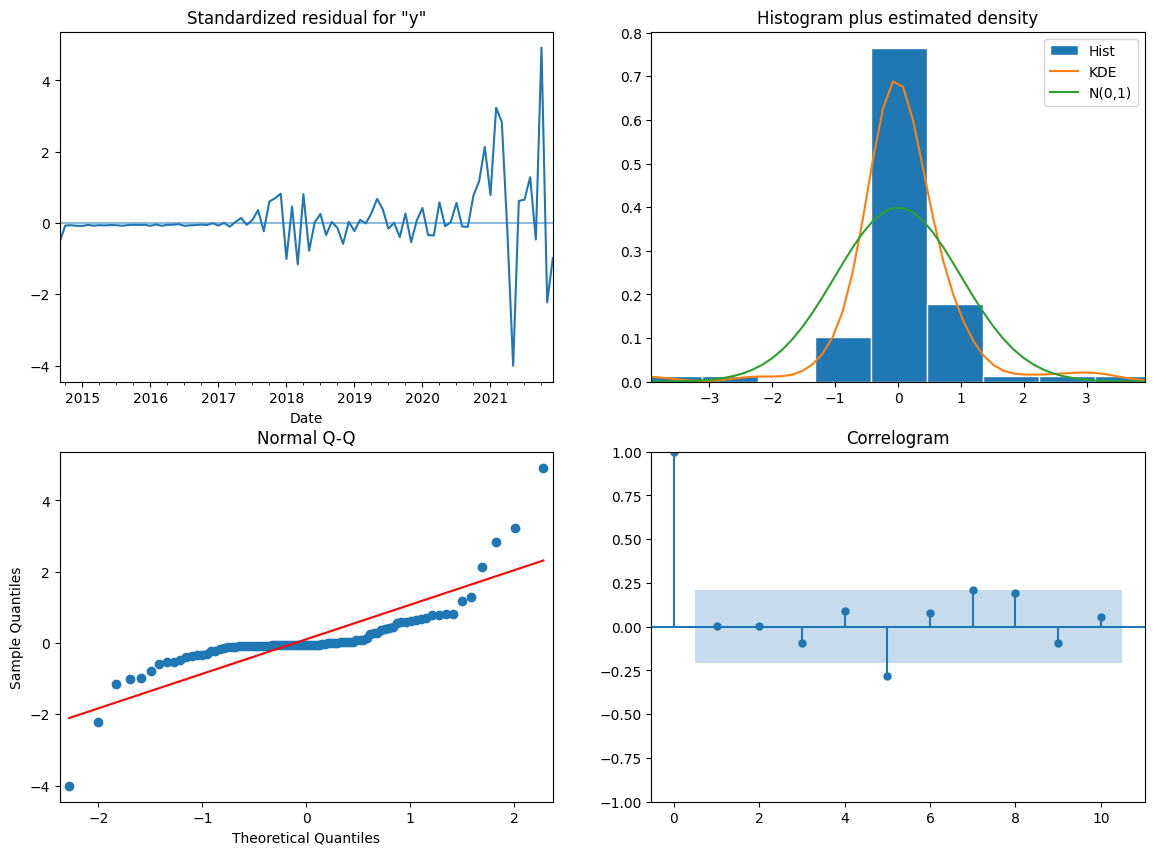

In [58]:
# summary of fit model
print(fitted_ar5.summary())
# residuals
resid_ar5 = DataFrame(fitted_ar5.resid)
# summary stats of residuals
print(resid_ar5.describe())
predictions_ar5 = predictions = fitted_ar5.forecast(len(test))
fig = fitted_ar5.plot_diagnostics(figsize=(14,10))
plt.show()

<Axes: xlabel='ds'>

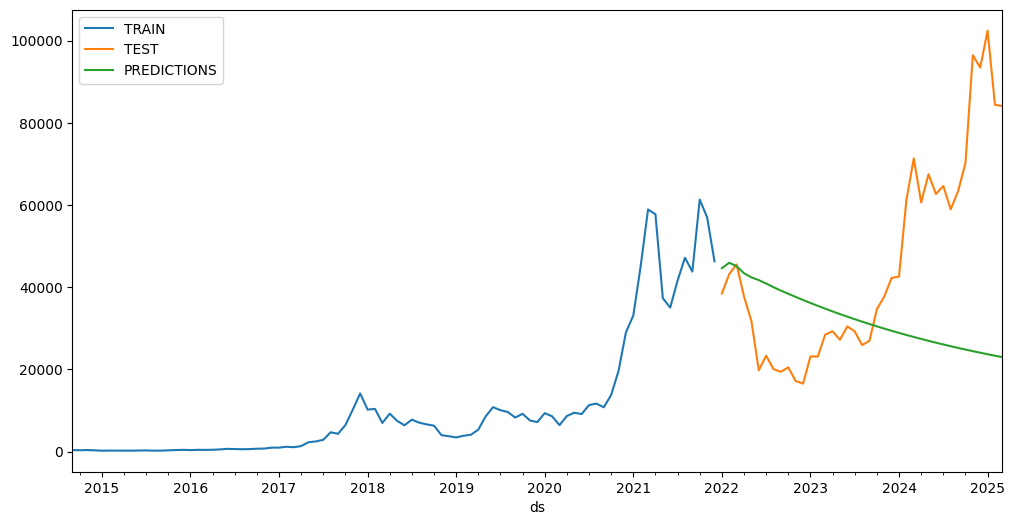

In [59]:
predictions_ar5 = predictions = fitted_ar5.forecast(len(test))
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':predictions_ar5}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo MA

## MA(7)

In [60]:
ma7 = ARIMA(train, order=(0,0,7))
fitted_ma7 = ma7.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:                 ARIMA(0, 0, 7)   Log Likelihood                -877.190
Date:                Sun, 30 Mar 2025   AIC                           1772.380
Time:                        23:12:53   BIC                           1794.676
Sample:                    09-30-2014   HQIC                          1781.362
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.081e+04   5630.097      1.919      0.055    -229.329    2.18e+04
ma.L1          1.3887      1.637      0.848      0.396      -1.820       4.598
ma.L2          1.2241      0.722      1.696      0.0

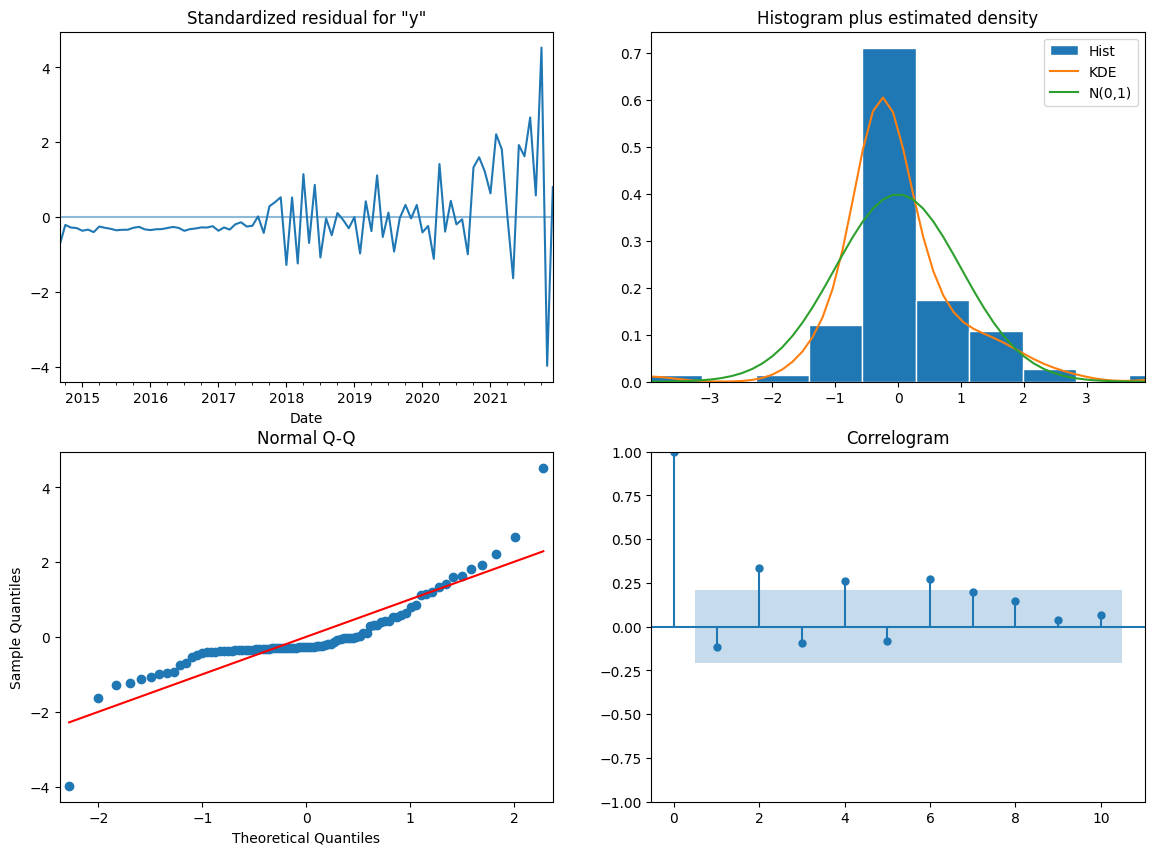

In [61]:
# summary of fit model
print(fitted_ma7.summary())
# residuals
resid_ma7 = DataFrame(fitted_ma7.resid)
# summary stats of residuals
print(resid_ma7.describe())
predictions_ma7 = predictions = fitted_ma7.forecast(len(test))
fig = fitted_ma7.plot_diagnostics(figsize=(14,10))
plt.show()

<Axes: xlabel='ds'>

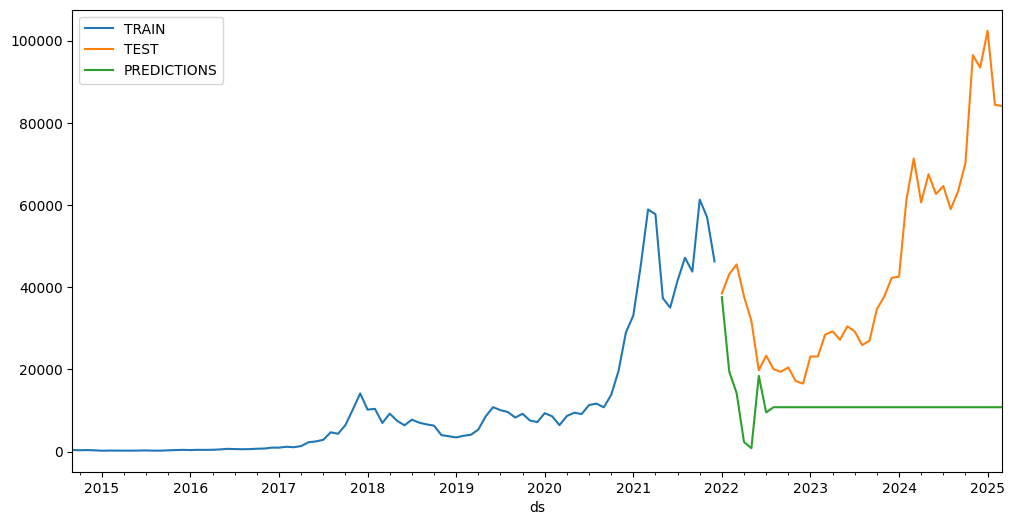

In [62]:
predictions_ma7 = predictions = fitted_ma7.forecast(len(test))
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':predictions_ma7}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Conclusion

In [63]:
def metrics(test, predictions):
  # Cálculo das métricas de avaliação
  mse = mean_squared_error(test['y'], predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test['y'], predictions)
  r2 = r2_score(test['y'], predictions)

  # Calcular MAPE (Mean Absolute Percentage Error)
  mape = np.mean(np.abs((test['y'] - predictions) / test['y'])) * 100

  # Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
  smape = np.mean(2 * np.abs(test['y'] - predictions) /
                (np.abs(test['y']) + np.abs(predictions))) * 100

  # Exibir as métricas
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R²: {r2}")
  print(f"MAPE: {mape}")
  print(f"SMAPE: {smape}")


In [64]:
print('\nARIMA(5,1,7)')
metrics(test, predictions_517)

print('\nAR(5)')
metrics(test, predictions_ar5)

print('\nMA(7)')
metrics(test, predictions_ma7)


ARIMA(5,1,7)
MSE: 596627008.2747786
RMSE: 24425.949485634712
MAE: 20317.762281378782
R²: -0.01709487032317325
MAPE: 54.98958953591
SMAPE: 45.18757262854785

AR(5)
MSE: 1041421072.7004535
RMSE: 32271.05626874419
MAE: 24196.12558994259
R²: -0.7753538076544106
MAPE: 51.5053348433269
SMAPE: 55.81647533412387

MA(7)
MSE: 1780467932.9164875
RMSE: 42195.59139195098
MAE: 34042.48207420138
R²: -2.0352377217731394
MAPE: 66.9114462666767
SMAPE: 107.70349517523077
